In [2]:
# Import Dependencies
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import matplotlib.pyplot as plt
from joblib import dump, load
from pickle import dump
import sqlite3

In [3]:
df=pd.read_csv('Resources/sales.csv')
df

,Date,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year,promotion
0,2010-02-05,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5,1
1,2010-02-12,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6,1
2,2010-02-19,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7,1
3,2010-02-26,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8,1
4,2010-03-05,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,2012-09-28,10,3,False,19.99,19.99,133,2658.67,2012,9,28,39,0
3857,2012-10-05,10,3,False,19.99,19.99,133,2658.67,2012,10,5,40,0
3858,2012-10-12,10,3,False,19.99,19.99,127,2538.73,2012,10,12,41,0
3859,2012-10-19,10,3,False,19.99,19.99,133,2658.67,2012,10,19,42,0


In [4]:
df=df.drop(columns=['weekly_sales','year','month','day'])
df['Week_Of_Year']=df['week_of_year']
df['Promotion']=df['promotion']
del df['week_of_year']
del df['promotion']
df.head()

,Date,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,Week_Of_Year,Promotion
0,2010-02-05,1,1,False,9.99,7.99,245,5,1
1,2010-02-12,1,1,True,9.99,7.99,453,6,1
2,2010-02-19,1,1,False,9.99,7.99,409,7,1
3,2010-02-26,1,1,False,9.99,7.99,191,8,1
4,2010-03-05,1,1,False,9.99,9.99,145,9,0


In [5]:
# Reordering so the data reads a little better. 
df=df[['Date','Week_Of_Year','Store','Product','Promotion','Is_Holiday','Base Price','Price','Weekly_Units_Sold']]
df.head()

,Date,Week_Of_Year,Store,Product,Promotion,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,2010-02-05,5,1,1,1,False,9.99,7.99,245
1,2010-02-12,6,1,1,1,True,9.99,7.99,453
2,2010-02-19,7,1,1,1,False,9.99,7.99,409
3,2010-02-26,8,1,1,1,False,9.99,7.99,191
4,2010-03-05,9,1,1,0,False,9.99,9.99,145


In [6]:
df.to_csv('Resources/final_data.csv', index=False)

In [18]:
alpha_test_df=df[df['Date']>'2011-10-25']
test_df=alpha_test_df.drop(columns=['Date'])
test_df['Temp']='_'
test_df['Store'] = test_df['Temp'].str.cat(test_df['Store'].values.astype(str))
test_df['Product'] = test_df['Temp'].str.cat(test_df['Product'].values.astype(str))
test_df['Week_Of_Year'] = test_df['Temp'].str.cat(test_df['Week_Of_Year'].values.astype(str))
del test_df['Temp']
test_df.head()

,Week_Of_Year,Store,Product,Promotion,Is_Holiday,Base Price,Price,Weekly_Units_Sold
90,_43,_1,_1,0,False,10.99,10.99,183
91,_44,_1,_1,0,False,10.99,10.99,231
92,_45,_1,_1,0,False,10.99,10.99,108
93,_46,_1,_1,0,False,10.99,10.99,110
94,_47,_1,_1,0,True,10.99,10.99,121


In [8]:
train_df=df[df['Date']<'2011-10-25']
train_df=train_df.drop(columns=['Date'])
train_df['Temp']='_'
train_df['Store'] = train_df['Temp'].str.cat(train_df['Store'].values.astype(str))
train_df['Product'] = train_df['Temp'].str.cat(train_df['Product'].values.astype(str))
train_df['Week_Of_Year'] = train_df['Temp'].str.cat(train_df['Week_Of_Year'].values.astype(str))
del train_df['Temp']
train_df.head()

,Week_Of_Year,Store,Product,Promotion,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,_5,_1,_1,1,False,9.99,7.99,245
1,_6,_1,_1,1,True,9.99,7.99,453
2,_7,_1,_1,1,False,9.99,7.99,409
3,_8,_1,_1,1,False,9.99,7.99,191
4,_9,_1,_1,0,False,9.99,9.99,145


In [9]:
# Create features for X_train
X_train=train_df.drop(columns=['Weekly_Units_Sold'], axis = 1)

X_train=pd.get_dummies(X_train)

# Create target. 
y_train = train_df['Weekly_Units_Sold']

In [10]:
X_train.shape, y_train.shape

((2430, 68), (2430,))

In [11]:
# Create features for X_test
X_test=test_df.drop(columns=['Weekly_Units_Sold'], axis = 1)

X_test=pd.get_dummies(X_test)

# Create target. 
y_test = test_df['Weekly_Units_Sold']

In [12]:
model=GradientBoostingRegressor()
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculating Cross Validation Score across multiple testing sets
# scores = cross_val_score(model, X_train_scaled, y_train, cv=20)
# scores
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

0.9164608663894473
0.8238384866822475
47.80776505716195
0.8238384866822475


In [22]:
# save the model
dump(model, open('Resources/model_ts.pkl', 'wb'))
# save the scaler
dump(scaler, open('Resources/scaler_ts.pkl', 'wb'))

Text(0, 0.5, 'Feature Importance Score')

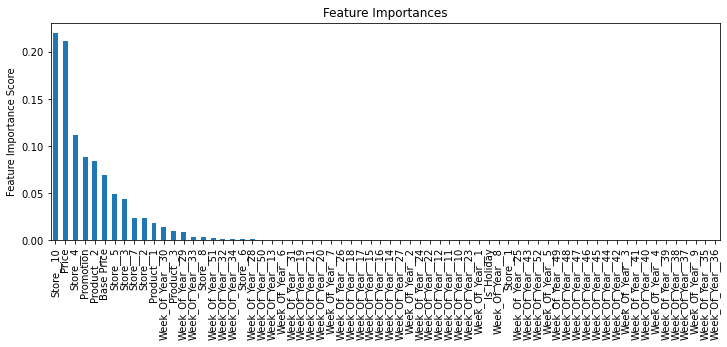

In [13]:
feat_imp = pd.Series(model.feature_importances_, X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [14]:
model=GradientBoostingRegressor(learning_rate=0.06, max_depth=9, n_estimators=1000, subsample=0.09)
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculating Cross Validation Score across multiple testing sets
# scores = cross_val_score(model, X_train_scaled, y_train, cv=20)
# scores
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

0.9883976875952702
0.901682438845715
38.93388006861782
0.901682438845715


In [15]:
Predicted_Sales_Units=pd.Series(pred)
Predicted_Sales_Units.describe()
Predicted_Sales_Units.isnull().sum()
Predicted_Sales_Units


0       226.869570
1       208.648207
2       129.971917
3       122.530428
4       119.777592
           ...    
1426    139.548910
1427    160.725855
1428    162.576993
1429    162.567070
1430    184.504302
Length: 1431, dtype: float64

In [21]:
alpha_test_df=df[df['Date']>'2011-10-25']
alpha_test_df=alpha_test_df.reset_index()
alpha_test_df['Predicted_Units_Sold']=Predicted_Sales_Units
alpha_test_df['Gross_Revenue']=alpha_test_df['Predicted_Units_Sold']*alpha_test_df['Price']
alpha_test_df=alpha_test_df.drop(columns=['Date','Weekly_Units_Sold'])
alpha_test_df.to_csv("Resources/gross_rev.csv")
alpha_test_df

,index,Week_Of_Year,Store,Product,Promotion,Is_Holiday,Base Price,Price,Predicted_Units_Sold,Gross_Revenue
0,90,43,1,1,0,False,10.99,10.99,226.869570,2493.296570
1,91,44,1,1,0,False,10.99,10.99,208.648207,2293.043790
2,92,45,1,1,0,False,10.99,10.99,129.971917,1428.391367
3,93,46,1,1,0,False,10.99,10.99,122.530428,1346.609409
4,94,47,1,1,0,True,10.99,10.99,119.777592,1316.355734
...,...,...,...,...,...,...,...,...,...,...
1426,3856,39,10,3,0,False,19.99,19.99,139.548910,2789.582702
1427,3857,40,10,3,0,False,19.99,19.99,160.725855,3212.909838
1428,3858,41,10,3,0,False,19.99,19.99,162.576993,3249.914080
1429,3859,42,10,3,0,False,19.99,19.99,162.567070,3249.715727
